This notebook generates prediction on tracking events based on a trained U-Net and generates lineages from the predictions.

Code adapted from: https://gitlab.com/dunloplab/delta

In [33]:
import numpy as np
import matplotlib.pyplot as plt;
import glob
import os
from tqdm import tqdm

import sys
sys.path.append('../delta')

from data import predictCompilefromseg_track #saveResult_track, 
from model import unet_track
import utilities as utils
from skimage.measure import label, regionprops
import skimage.io as io
from skimage.transform import resize

# Load data

In [34]:
DeLTA_data = '../../../ackermann-bacteria-segmentation/data/tracking/trial2/pos8/mCherry/'
images_folder = DeLTA_data + 'xy1/phase/'
segmentation_folder = DeLTA_data + 'seg_im/'
outputs_folder = DeLTA_data + 'evaluation/track_output/'
model_file = '../delta/model_weights/unet_moma_track_multisets.hdf5'

In [35]:
# set number of frames
num = 4

In [36]:
img_names_sort = np.sort(glob.glob(images_folder + '*frame*'))[:num]
seg_names_sort = np.sort(glob.glob(segmentation_folder + '*frame*'))[:num]

# Load model and set parameters

In [37]:
# generate input for unet

def gen_input(img_names_sort, seg_names_sort, cur_frame, target_shape):
    img_cur_frame = resize(io.imread(img_names_sort[cur_frame]), target_shape, order=1)
    img_prev_frame = resize(io.imread(img_names_sort[cur_frame - 1]), target_shape, order=1)
    seg_cur_frame = (resize(io.imread(seg_names_sort[cur_frame]), target_shape, order=0) > 0).astype(int)
    seg_prev_frame = (resize(io.imread(seg_names_sort[cur_frame-1]), target_shape, order=0) > 0).astype(int)
    
    label_prev_frame = label(seg_prev_frame)
    label_cells = np.unique(label_prev_frame)
    num_cells = len(label_cells) - 1
    
    input_cur_frame = np.empty((target_shape[0], target_shape[1], 4))
    input_cur_frame[:,:,0] = img_prev_frame
    input_cur_frame[:,:,1] = label(seg_prev_frame)
    input_cur_frame[:,:,2] = img_cur_frame
    input_cur_frame[:,:,3] = seg_cur_frame
    return input_cur_frame

In [38]:
# Parameters:
target_size = (512, 512)
input_size = target_size + (4,)
num_time_steps = len(img_names_sort)

# Load up model:
model = unet_track(input_size = input_size)
model.load_weights(model_file)

# Run model to predict cell splits

In [39]:
# Process
results_all = []
inputs_all = []
inputs_seg = []
time_points = []

for cur_frame in tqdm(range(1, num_time_steps)):
    inputs = gen_input(img_names_sort, seg_names_sort, cur_frame, target_size)
    if inputs.any():
        results_ar = []

        cell_ids = np.unique(inputs[:,:,1])[1:].astype(int)
        for i in cell_ids:
            seed = (inputs[:,:,1] == i).astype(int)
            inputs_cell = np.empty(inputs.shape)
            inputs_cell[:,:,[0,2,3]] = inputs[:,:,[0,2,3]]
            inputs_cell[:,:,1] = seed
            results = model.predict(np.array((inputs_cell,)),verbose=0)
            results_ar.append(results[0,:,:,:])
            

        results_all.append(np.array(results_ar))
        inputs_seg.append(inputs[:,:,3])
        inputs_all.append(inputs)


100%|██████████| 3/3 [00:43<00:00, 14.35s/it]


# Generate lineages based on model output

In [11]:
# create input variables for lineage generation
timepoints=len(inputs_all) - 1
chamber_number = 0
num_track_events = [(len(np.unique(i[:,:,1]))-1) for i in inputs_all[:timepoints]]
frame_numbers = np.concatenate([[i]*num_track_events[i] for i in range(timepoints)])
seg = np.array([i[:,:,3] for i in inputs_all[:timepoints]])
track_inputs = np.array([i for i in inputs_all[:timepoints]])
track = np.concatenate([i for i in results_all[:timepoints]])

In [13]:
# generate lineages
label_stack = np.zeros([timepoints,seg.shape[1],seg.shape[2]],dtype=np.uint16)
lin, label_stack = utils.updatelineage(seg[chamber_number*timepoints], label_stack) # Initialize lineage and label stack on first frame
for i in tqdm(range(1,timepoints)):
    frame_idxs = [x for x, fn in enumerate(frame_numbers) if fn==i]
    if frame_idxs:
        scores = utils.getTrackingScores(track_inputs[i,:,:,3], track[frame_idxs])
        attrib = utils.getAttributions(scores)
    else:
        attrib = []
    lin, label_stack = utils.updatelineage(seg[chamber_number*timepoints + i], label_stack, framenb=i, lineage=lin, attrib=attrib) # Because we use uint16, we can only track up to 65535 cells per chamber

100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


# Save ouput

In [15]:
# reduce results file for storage
results_all_red = np.empty((len(results_all), *results_all[0][0,:,:,:2].shape))
for t in range(len(results_all)):
    for ix, cell_id in enumerate(results_all[t]):
        results_all_red[t,cell_id[:,:,0] > 0.9, 0] = ix+1
        results_all_red[t,cell_id[:,:,1] > 0.9, 1] = ix+1

# Visualize output

## Tracking network

Text(0.5, 1.0, 'Daughter')

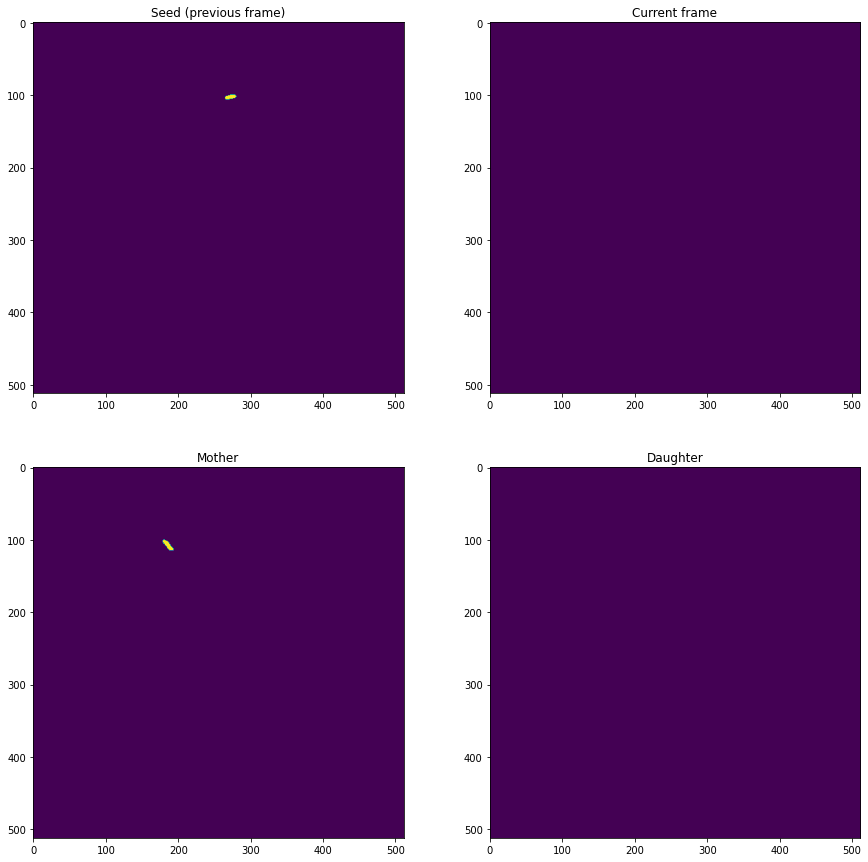

In [27]:
frame = 2
cell_ix = 20

plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.imshow(inputs_all[frame][:,:,1]==cell_ix)
plt.title('Seed (previous frame)')
plt.subplot(2,2,2)
plt.imshow(inputs_all[frame][:,:,3]==cell_ix)
plt.title('Current frame')
plt.subplot(2,2,3)
plt.imshow(results_all_red[frame,:,:,0]==(cell_ix+1))
plt.title('Mother')
plt.subplot(2,2,4)
plt.imshow(results_all_red[frame,:,:,1]==(cell_ix+1))
plt.title('Daughter')

## Lineages

### Labeled cells

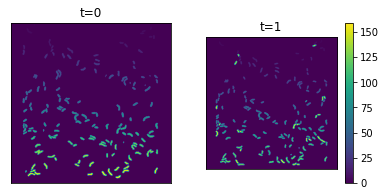

In [28]:
timeframes = np.arange(len(label_stack))
plt.figure(figsize = (10,10))
for i, l in enumerate(label_stack[::1]):
    plt.subplot(3,3,i+1)
    plt.imshow(l, vmin=label_stack.min())
    plt.title('t='+str(timeframes[::1][i]))
    plt.xticks([])
    plt.yticks([])
plt.colorbar()

### Features

In [29]:
def compute_area(cell_id):
    areas = []
    for i in range(num_time_steps-2):
        regs_cell = regionprops((label_stack[i] == cell_id).astype(int))
        try:
            areas.append(regs_cell[0].area)
        except IndexError:
            areas.append(0)
    areas = np.array(areas)
    return areas

def compute_length(cell_id):
    lengths = []
    for i in range(num_time_steps-2):
        regs_cell = regionprops((label_stack[i] == cell_id).astype(int))
        try:
            lengths.append(regs_cell[0].major_axis_length)
        except IndexError:
            lengths.append(0)
    lengths = np.array(lengths)
    return lengths

In [30]:
# Compute features

area = compute_area(cell_id = 10)
length = compute_length(cell_id = 10)

Text(0.5, 0, 'Time frame')

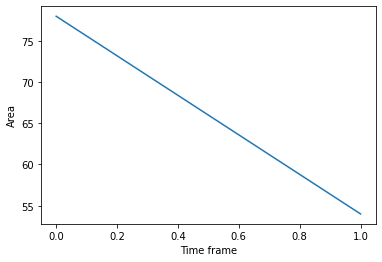

In [31]:
plt.plot(area)
plt.ylabel('Area')
plt.xlabel('Time frame')

Text(0.5, 0, 'Time frame')

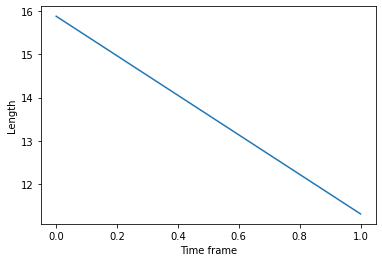

In [32]:
plt.plot(length)
plt.ylabel('Length')
plt.xlabel('Time frame')